In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cartopy.crs as ccrs
from pyresample import geometry, grid
import pyresample
import matplotlib.pyplot as plt
import datetime
import metpy
import datetime
import xarray as xr
from pyresample import geometry, grid
import cartopy.crs as ccrs
from sklearn.metrics import mean_squared_error
import math
from skimage.transform import resize
from skimage.transform import resize_local_mean
import tensorflow as tf
import tensorflow_hub as hub
from skimage.filters import laplace
from skimage.filters import unsharp_mask

random.seed(42)

/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")
2022-08-03 15:57:15.680856: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 15:57:15.680894: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
shape = [500, 500]
pc_extents = [-124.25, 32.25, -114.25, 42.25]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

In [5]:
goes_path = '../landsat_files/'
landsat_path = '../landsat_files/landsat_files/'

day1 = {'goes':'2021240', 'landsat':'20210828'}
day2 = {'goes':'2021247', 'landsat':'20210904'}

a1 = {'day':day1, 'loc':'A', 'lat_0':40.49, 'lon_0':-121.45, 'lat_f':40.650000000000006, 'lon_f':-121.17}
b1 = {'day':day1, 'loc':'B', 'lat_0':39.91, 'lon_0':-120.97, 'lat_f':40.13, 'lon_f':-120.49000000000001}
a2 = {'day':day2, 'loc':'A', 'lat_0':40.707499999999996, 'lon_0':-123.4325, 'lat_f':41.1325, 'lon_f':-122.7075}
b2 = {'day':day2, 'loc':'B', 'lat_0':41.027499999999996, 'lon_0':-123.0925, 'lat_f':41.31250000000001, 'lon_f':-122.6875}


subsets = [a1, b1, a2, b2]

In [6]:
def latslons(subset):
    coords_0 = target_area.get_array_coordinates_from_lonlat(subset['lon_0'], subset['lat_0'])
    coords_0 = (round(coords_0[0]), round(coords_0[1]))
    coords_f = target_area.get_array_coordinates_from_lonlat(subset['lon_f'], subset['lat_f'])
    coords_f = (round(coords_f[0]), round(coords_f[1]))
    subset['lons'] = [coords_0[0], coords_f[0]]
    subset['lats'] = [coords_f[1], coords_0[1]]

In [7]:
def pixshifts(subset):
    
    for file in os.listdir(landsat_path):
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'red_grid' + subset['loc'] + 'cent0.02deg.npy':
            refimg = np.flipud(np.load(landsat_path + file))

    for file in os.listdir(goes_path):
        if file[:34] == 'OR_ABI-L1b-RadC-M6C02_G17_s' + subset['day']['goes']:
            newimg_full = np.load(goes_path + file)
    
    lats = subset['lats']
    lons = subset['lons']

    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    
    x_add = 0
    y_add = 0
    
    while refimg.shape != newimg.shape: 
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
        
        newimg = newimg_full[lats[0]:lats[1] + x_add, lons[0]:lons[1] + y_add]
    
    lats[1] += x_add
    lons[1] += y_add

    nx = 1
    ny = 1
    x_shift = np.arange(-nx, nx+1)
    y_shift = np.arange(-ny, ny+1)
    scores = []
    
    for x in x_shift:
        for y in y_shift:
            testimg = newimg_full[lats[0]+x:lats[1]+x, lons[0]+y:lons[1]+y]
            scores.append([x, y, np.corrcoef(refimg.flatten(), testimg.flatten())[0, 1]])
    
    max_score = 0
    min_score_index = 0
    
    for score_index in range(len(scores)-1):
        score = scores[score_index][-1]
        if abs(score) > abs(max_score):
            max_score = score
            max_score_index = score_index
            
    min_x, min_y, max_score = scores[max_score_index]
    subset['shift'] = [min_x, min_y]

In [52]:
def crop(refimg, newimg_full, min_x, min_y, lats, lons):
    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    
    nx = 0
    ny = 0
    
    x_add = 0
    y_add = 0
    
    while refimg.shape != newimg.shape:
        x_add = 0
        y_add = 0
    
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        newimg = newimg_full[lats[0]:lats[1] + nx, lons[0]:lons[1] + ny]

    lats[1] += x_add
    lons[1] += y_add
    
    result = newimg_full[lats[0]+min_x:lats[1]+min_x, lons[0]+min_y:lons[1]+min_y]
    
#     if result.shape[0] % 2 != 0:
#         result = result[:-1,:]
#     if result.shape[1] % 2 != 0:
#         result = result[:,:-1]

    return result

In [57]:
def applySR(subset):
    for file in os.listdir(landsat_path):
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_039 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_103 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_039 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_103 = np.flipud(np.load(landsat_path + file))

    for file in os.listdir(goes_path):
        if file[:34] == 'OR_ABI-L1b-RadC-M6C07_G17_s' + subset['day']['goes']:
            goes_img_039 = np.load(goes_path + file)
        if file[:34] == 'OR_ABI-L1b-RadC-M6C14_G17_s' + subset['day']['goes']:
            goes_img_103 = np.load(goes_path + file)
            
    new_landsat_diff = new_landsat_img_039 - new_landsat_img_103
    subset['landsat_diff'] = new_landsat_diff
    
    goes_img_original_039 = crop(landsat_img_039, goes_img_039, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])
    goes_img_original_103 = crop(landsat_img_103, goes_img_103, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])
    subset['goes_img'] = goes_img_original_039 - goes_img_original_103

In [54]:
for subset in subsets:
    latslons(subset)
    pixshifts(subset)
    applySR(subset)

In [55]:
a1['landsat_img'] = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridAcent0.02deg.npy') - np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridAcent0.02deg.npy')
b1['landsat_img'] = np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT3.9_gridBcent0.02deg.npy') - np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_BT10.3_gridBcent0.02deg.npy')
a2['landsat_img'] = np.load(landsat_path + 'LC08_L2SP_045032_20210904_20210910_02_T1_goesLS_BT3.9_gridAcent0.02deg.npy') - np.load(landsat_path + 'LC08_L2SP_045032_20210904_20210910_02_T1_goesLS_BT10.3_gridAcent0.02deg.npy')
b2['landsat_img'] = np.load(landsat_path + 'LC08_L2SP_045031_20210904_20210910_02_T1_goesLS_BT3.9_gridBcent0.02deg.npy') - np.load(landsat_path + 'LC08_L2SP_045031_20210904_20210910_02_T1_goesLS_BT10.3_gridBcent0.02deg.npy')

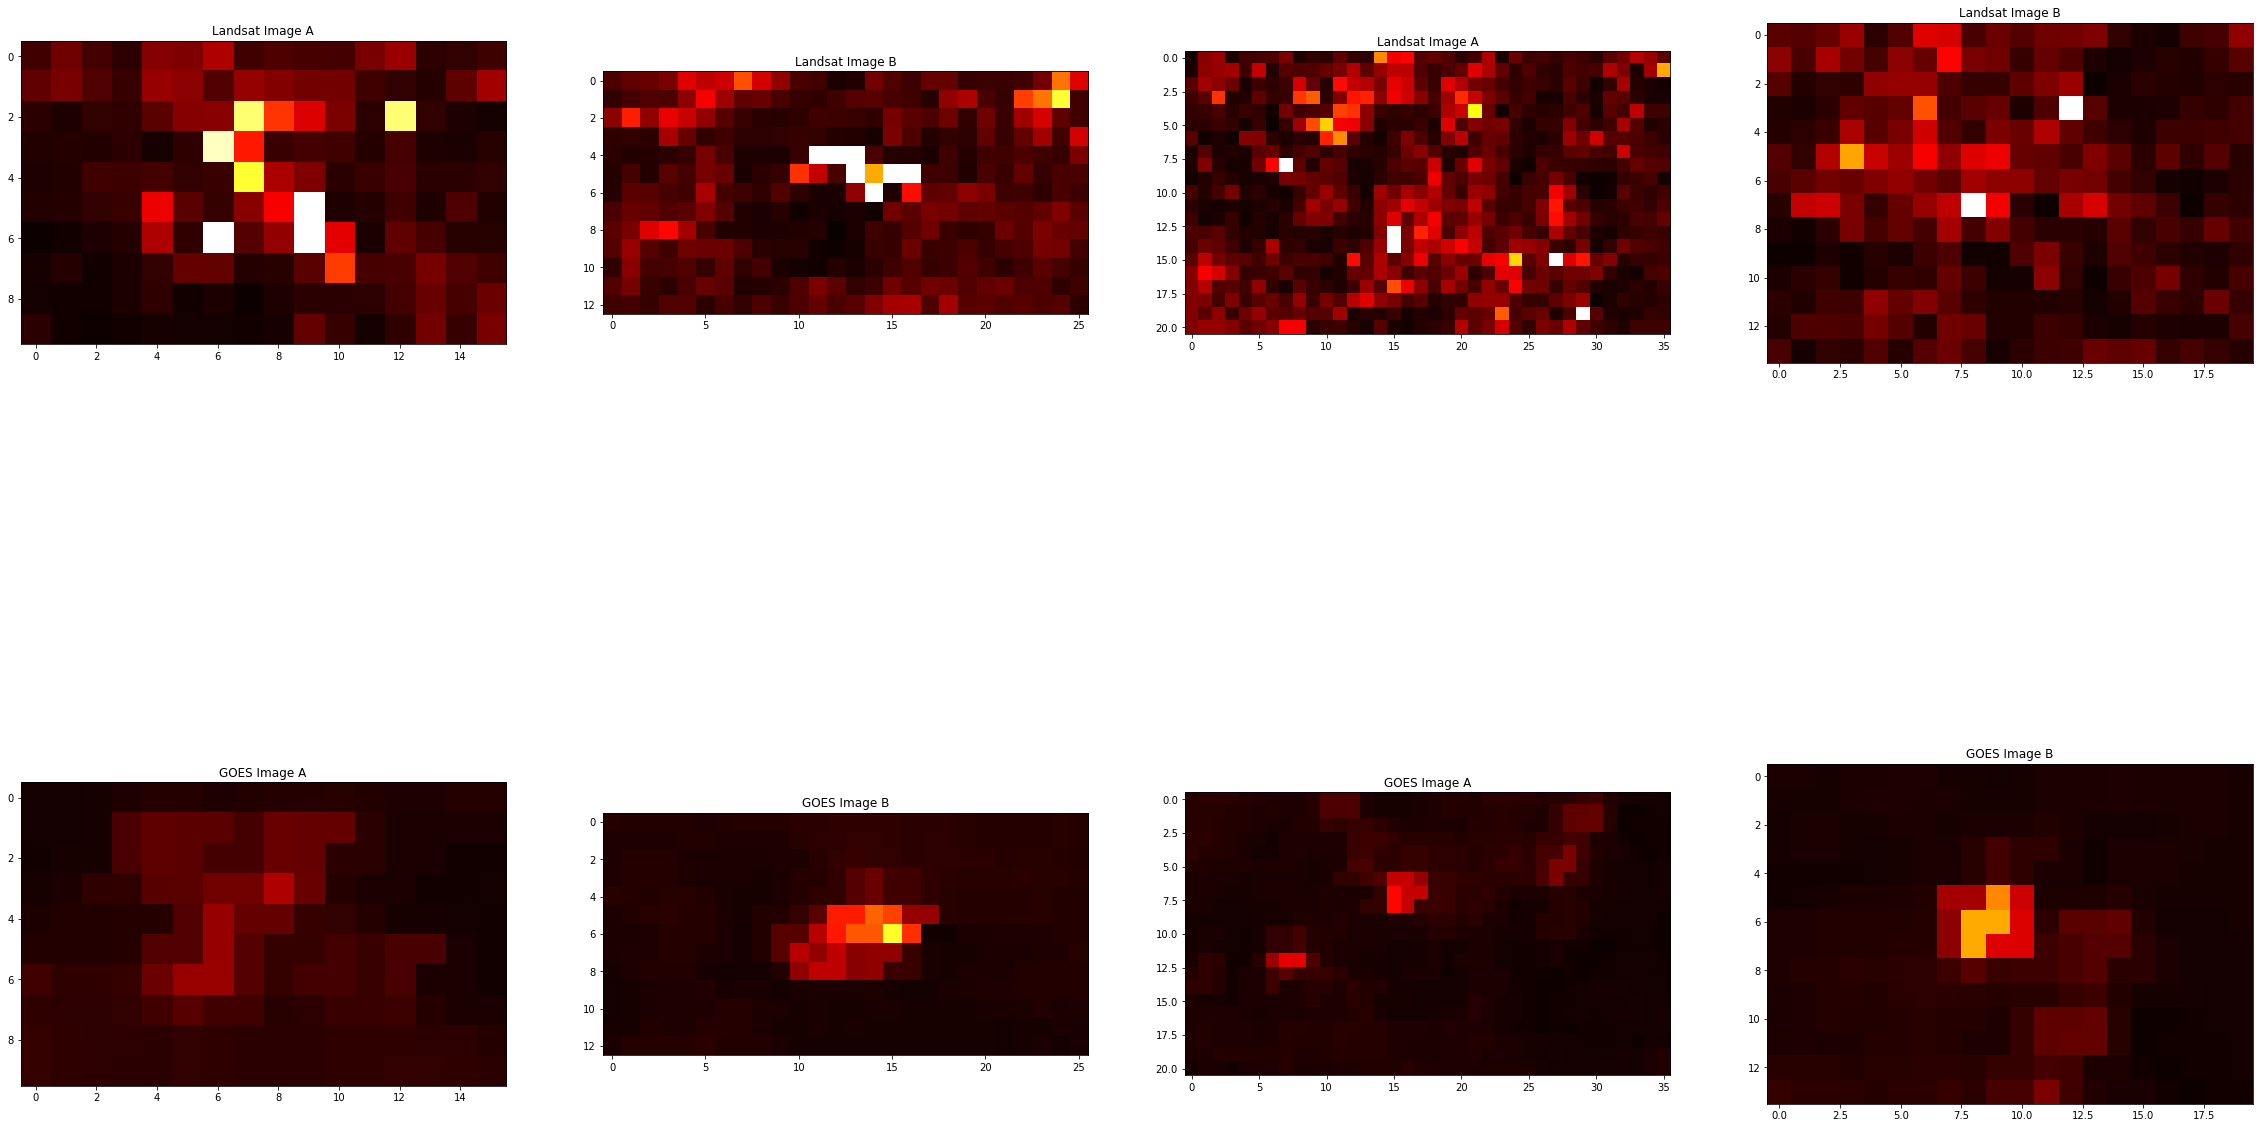

In [56]:
f, (ax1, ax2) = plt.subplots(2, 4, figsize=(40, 25))
axs = [ax1, ax2]

max_temp = 100
min_temp = 0

for n in range(4):
    subset = subsets[n]
    
    ax1[n].imshow(100*subset['landsat_img'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax1[n].set_title('Landsat Image ' + subset['loc'])
    
    ax2[n].imshow(subset['goes_img'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax2[n].set_title('GOES Image ' + subset['loc'])

In [58]:
for n in range(4):
    subset = subsets[n]
    np.save('Landsat Subsets/landsat' + subset['day']['goes'] + subset['loc'] + '.npy', subset['landsat_img'])
    np.save('Landsat Subsets/goes' + subset['day']['goes'] + subset['loc'] + '.npy', subset['goes_img'])